In [15]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report,roc_curve,auc
from sklearn.utils.class_weight import compute_class_weight
from lime import lime_image  # For LIME interpretability
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

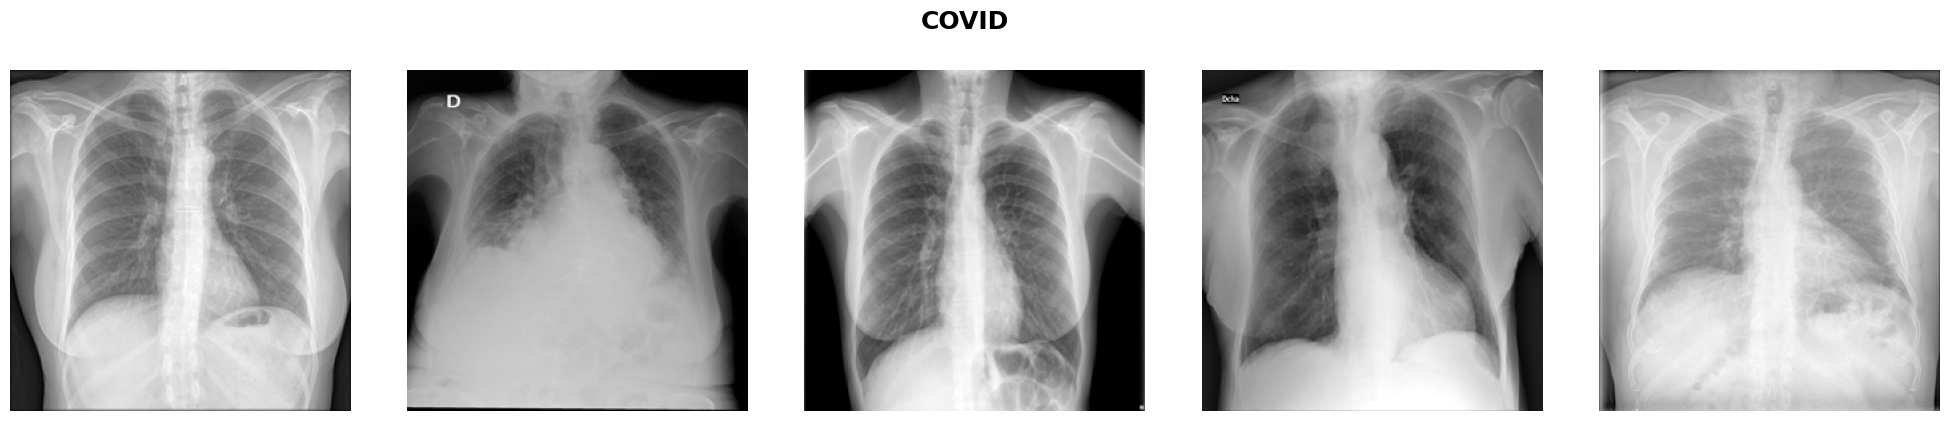

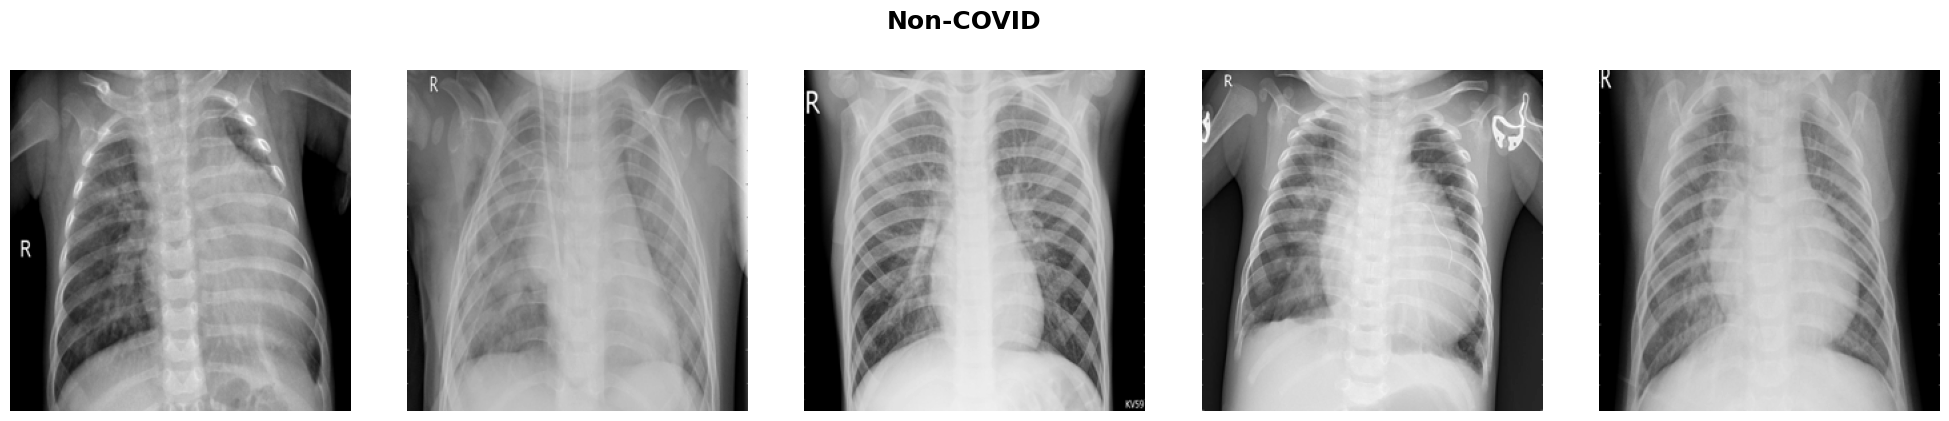

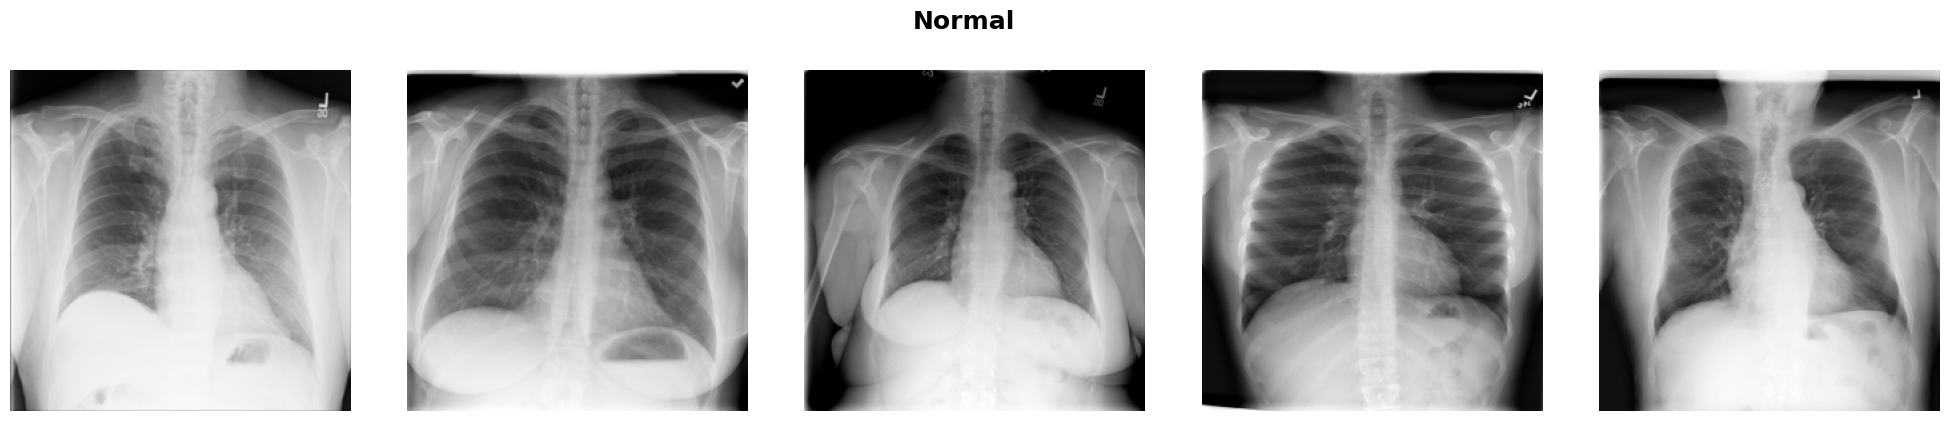

In [2]:
# Define a function to plot a set of images
def plot_images(image_dir, label):
    # Get a list of the filenames in the directory
    filenames = os.listdir(image_dir)
    # Take the first 5 filenames
    filenames = filenames[:5]
    # Plot each image in a subplot
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    fig.tight_layout(pad=1)
    fig.suptitle(label, fontsize=18, fontweight="bold")
    for i, filename in enumerate(filenames):
        img_path = os.path.join(image_dir, filename)
        img = plt.imread(img_path)
        axs[i].imshow(img, cmap = 'gray')
        axs[i].axis("off")
    plt.show()

# Plot the images for each set
plot_images("CovidXRayImages/Val/COVID-19/Images", "COVID")
plot_images("CovidXRayImages/Val/Non-COVID/Images", "Non-COVID")
plot_images("CovidXRayImages/Val/Normal/Images", "Normal")


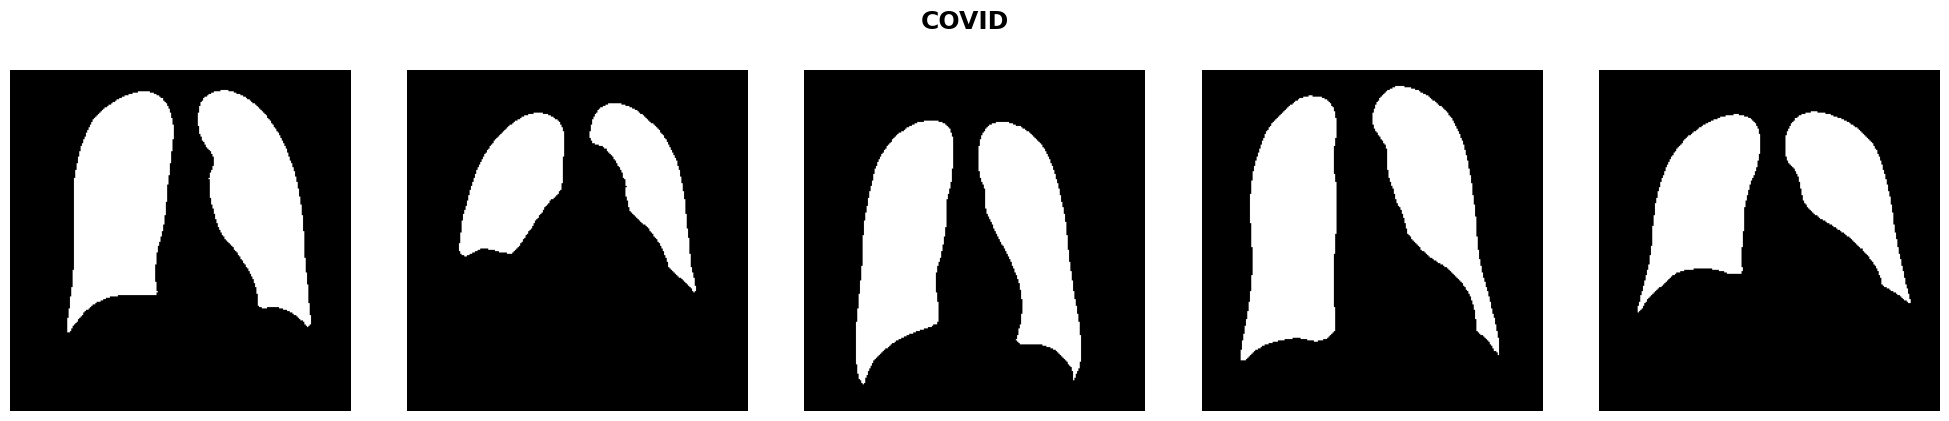

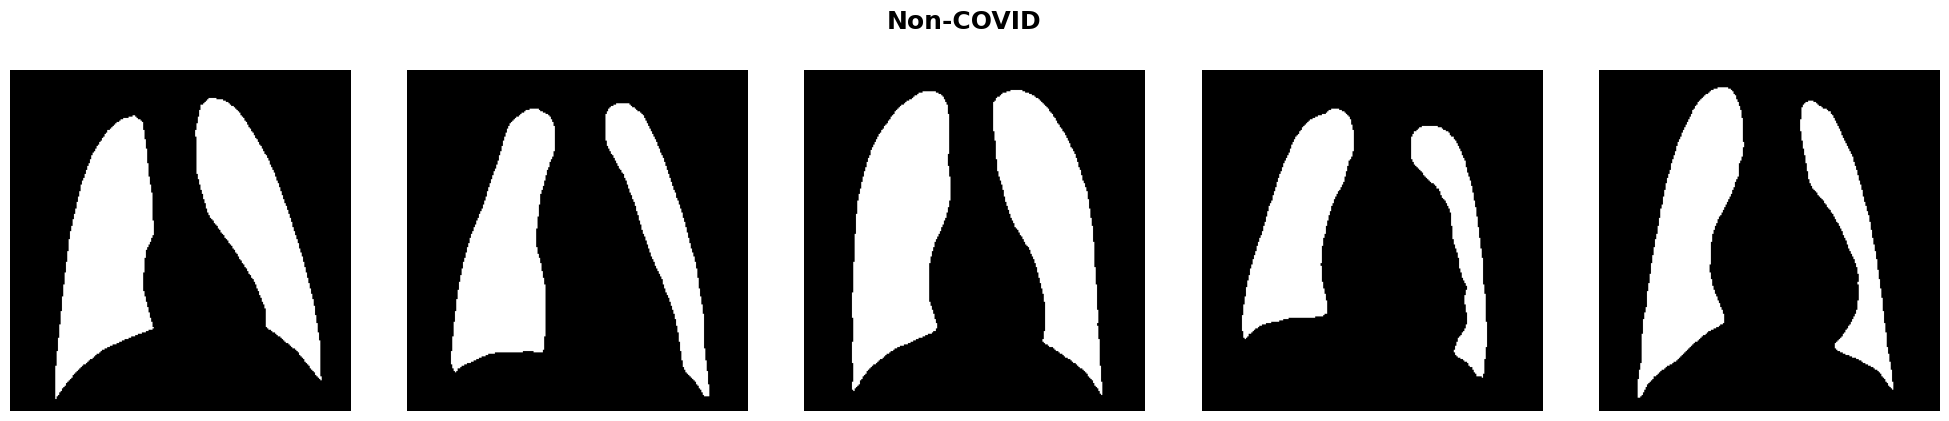

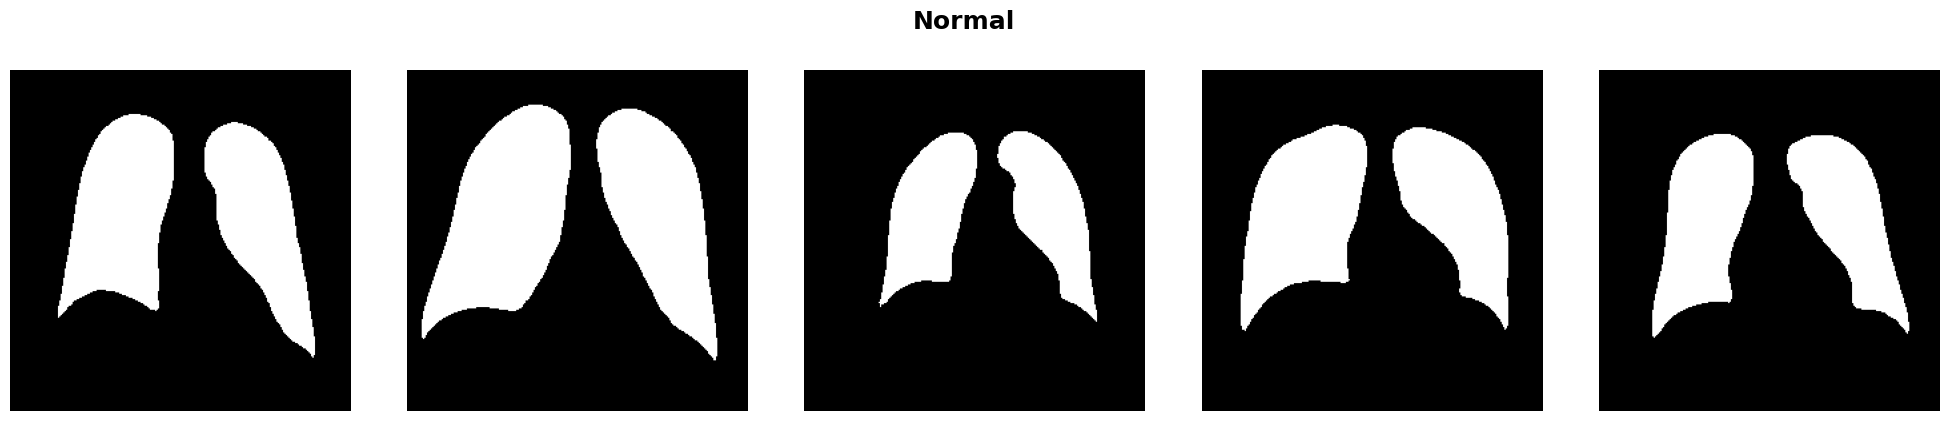

In [3]:
# Define a function to plot a set of images
def plot_images(image_dir, label):
    # Get a list of the filenames in the directory
    filenames = os.listdir(image_dir)
    # Take the first 5 filenames
    filenames = filenames[:5]
    # Plot each image in a subplot
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    fig.tight_layout(pad=1)
    fig.suptitle(label, fontsize=18, fontweight="bold")
    for i, filename in enumerate(filenames):
        img_path = os.path.join(image_dir, filename)
        img = plt.imread(img_path)
        axs[i].imshow(img, cmap = 'gray')
        axs[i].axis("off")
    plt.show()

# Plot the images for each set
plot_images("CovidXRayImages/Val/COVID-19/lung masks", "COVID")
plot_images("CovidXRayImages/Val/Non-COVID/lung masks", "Non-COVID")
plot_images("CovidXRayImages/Val/Normal/lung masks", "Normal")


In [4]:

def data_process(base_dir, categories):
    data = []
    labels = []

    for class_num, category in enumerate(categories):
        image_folder = os.path.join(base_dir, category, "images")
        mask_folder = os.path.join(base_dir, category, "lung masks")

        for filename in os.listdir(image_folder):
            try:
                img_path = os.path.join(image_folder, filename)
                mask_path = os.path.join(mask_folder, filename)

                img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
                img = np.expand_dims(img / 255.0, axis=-1).repeat(3, axis=-1)
                mask = cv2.imread(mask_path)

                if img is None:
                    print(f"Error: Image {img_path} could not be loaded.")
                    continue

                if mask is None:
                    print(f"Error: Mask {mask_path} could not be loaded.")
                    continue

                img_size = (150, 150)

                # Resize the images
                img = cv2.resize(img, img_size)
                mask = cv2.resize(mask, img_size)

                # Combine the image and the mask
                combined = np.dstack((img, mask)) / 255.0
                data.append(img)
                labels.append(class_num)
            except Exception as e:
                print(f"Error processing image {filename}: {e}")

    return np.array(data), np.array(labels)

X_ray_images, labels = data_process("CovidXRayImages/Val/", ["COVID-19", "Non-COVID", "Normal"])


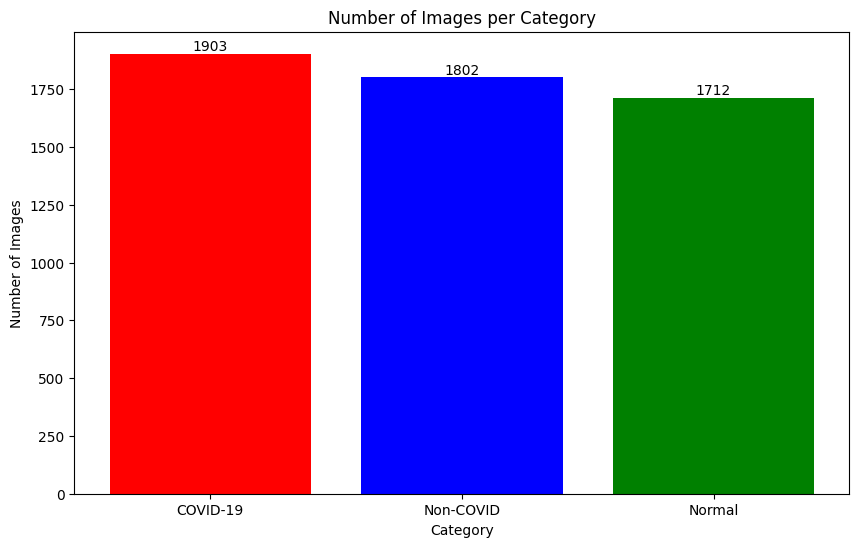

In [10]:

# Count the number of images in each category
categories = ["COVID-19", "Non-COVID", "Normal"]
category_counts = [np.sum(labels == i) for i in range(len(categories))]

# Plot the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, category_counts, color=['red', 'blue', 'green'])

# Adding the count numbers on the tips of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, int(height), ha='center', va='bottom')

plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Number of Images per Category')
plt.show()


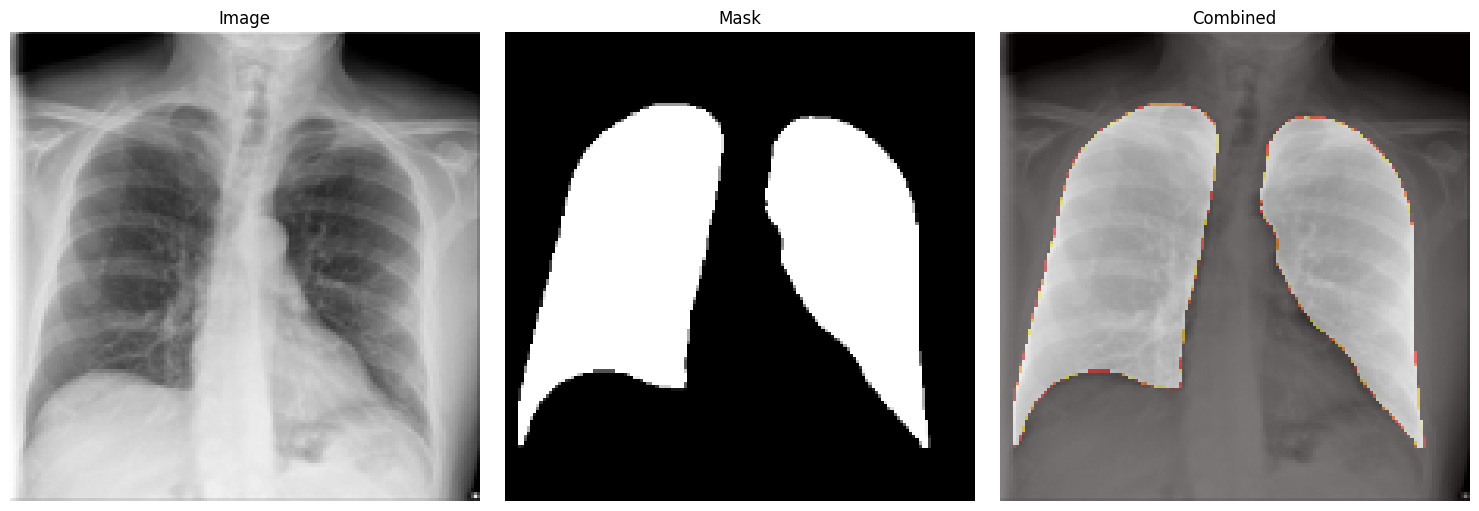

In [6]:
import matplotlib.pyplot as plt

sample = X_ray_images[600]
# Extract image and mask channels efficiently using indexing
image = sample[..., 0]  # Access first channel ( grayscale image)
mask = sample[..., 1]  # Access second channel ( mask)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
# Display grayscale image
ax1.imshow(image, cmap='gray')
ax1.set_title('Image')
ax1.axis('off')
# Display mask with transparency
ax2.imshow(image, cmap='gray')  # Base image for combined view
ax2.imshow(mask, cmap='gray')  # Overlay mask with transparency
ax2.set_title('Mask')
ax2.axis('off')
# Display combined image with colormap for mask strength
ax3.imshow(image, cmap='gray')
ax3.imshow(mask, cmap='hot', alpha=0.5)  # Use 'hot' colormap for mask intensity
ax3.set_title('Combined')
ax3.axis('off')
plt.tight_layout()  
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_ray_images, labels, test_size=0.2, random_state=42)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
# Define the augmentation configuration for training data
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for the testing data, only rescaling
test_datagen = ImageDataGenerator()

# Fit the datagen to the training data
train_datagen.fit(X_train)

In [7]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
class_weights 

{0: 0.9648185259407704, 1: 0.9798733604703754, 2: 1.0604503181595692}

In [8]:
X_train[0].shape

(150, 150, 3)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define a simple CNN model
model = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150,3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(categories), activation='softmax')
])

In [23]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [24]:
# Use early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [25]:
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    epochs=30,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 54s 386ms/step - accuracy: 0.3526 - loss: 1.1024 - val_accuracy: 0.4991 - val_loss: 0.9970
Epoch 2/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 55s 398ms/step - accuracy: 0.4594 - loss: 1.0448 - val_accuracy: 0.6273 - val_loss: 0.8882
Epoch 3/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 58s 420ms/step - accuracy: 0.5527 - loss: 0.9480 - val_accuracy: 0.6559 - val_loss: 0.8462
Epoch 4/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 64s 465ms/step - accuracy: 0.5676 - loss: 0.9165 - val_accuracy: 0.6513 - val_loss: 0.7801
Epoch 5/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 64s 462ms/step - accuracy: 0.6010 - loss: 0.8709 - val_accuracy: 0.6753 - val_loss: 0.7660
Epoch 6/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 63s 461ms/step - accuracy: 0.6055 - loss: 0.8539 - val_accuracy: 0.7076 - val_loss: 0.7210
Epoch 7/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 63s 460ms/step - accuracy: 0.6255 - loss: 0.8354 - val_accuracy: 0.5886 - val_loss: 0.8664
Epoch 8/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 63s 455ms/step - accuracy: 0.6467 - loss: 0

In [26]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")


34/34 - 4s - 129ms/step - accuracy: 0.8063 - loss: 0.5094
Test accuracy: 0.8062730431556702


In [27]:
# Evaluate the model on the training data
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=2)
print(f"Train accuracy: {train_acc}")

136/136 - 20s - 144ms/step - accuracy: 0.7895 - loss: 0.5427
Train accuracy: 0.7895222902297974


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step


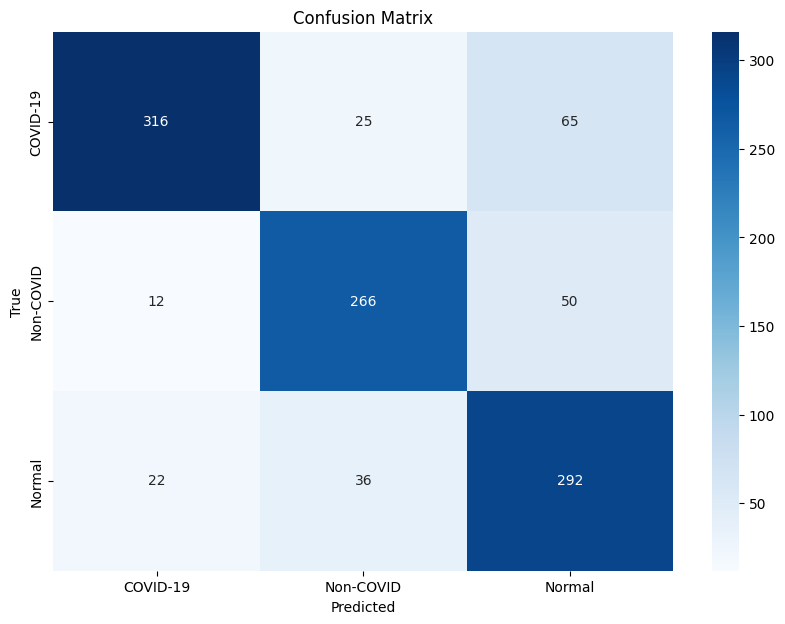

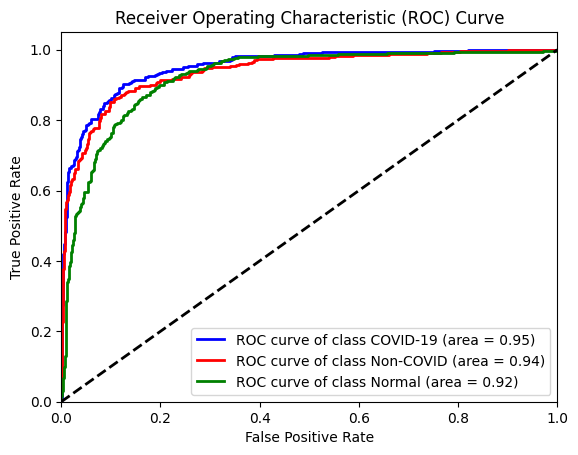

In [28]:
# Predict the labels for the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["COVID-19", "Non-COVID", "Normal"], yticklabels=["COVID-19", "Non-COVID", "Normal"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve for each class
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i, color in zip(range(n_classes), ['blue', 'red', 'green']):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(["COVID-19", "Non-COVID", "Normal"][i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [66]:
import cv2
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf

# Load your pre-trained model
model = load_model('test_80.h5') 

# Define the model prediction function
def model_predict(images):
    # Preprocess the images as required by your model
    images_preprocessed = preprocess_input(images)
    # Predict class probabilities
    predictions = model.predict(images_preprocessed)
    
    # If predictions are one-hot encoded, convert them to probabilities
    if np.argmax(predictions, axis=-1).sum() == predictions.shape[0]:  # Check if they are one-hot encoded
        probabilities = tf.nn.softmax(predictions, axis=-1).numpy()
    else:
        probabilities = predictions

    return probabilities

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

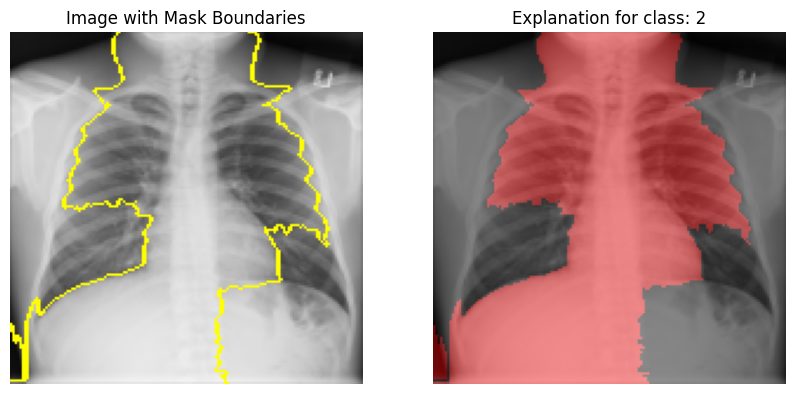

In [65]:
# Load and preprocess the image
img_path = r"C:\Users\zuhai\Downloads\CovidXRayImages\Val\Normal\images\normal (643).png"
img = cv2.imread(img_path)  # Read the image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
img = cv2.resize(img, (150, 150), interpolation=cv2.INTER_AREA)  # Resize the image to 150x150 pixels

# Create a LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the image
explanation = explainer.explain_instance(img, model_predict, top_labels=3, hide_color=0, num_samples=1000)

# Get the image and mask for the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True,  hide_rest=False)

# Create an image with transparent mask
overlay = label2rgb(mask, image=img, alpha=0.4, bg_label=0, kind='overlay')

# Display the explanation with mask boundaries
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Original image with mask boundaries
ax[0].imshow(mark_boundaries(img / 255.0, mask))
ax[0].set_title('Image with Mask Boundaries')
ax[0].axis('off')

# Image with transparent mask overlay
ax[1].imshow(overlay)
ax[1].set_title(f'Explanation for class: {explanation.top_labels[0]}')
ax[1].axis('off')

plt.show()

In [31]:
model.save('test_80.h5')